# Objective
### This project aims to forecast housing prices in Chandler, Arizona, using Redfin.com listings for single-family homes only.

#### The analysis focuses on four key use cases:

Investor Opportunity Analysis

Pricing Strategies for Sellers

Value Zones for Potential Buyers

Strategic Housing Acquisition: Identifying undervalued single-family homes in Chandler

Note: School districts—an important driver of real estate pricing—were excluded from this analysis due to data limitations.


In [36]:
import pandas as pd
import numpy as np
import os
import sklearn 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv("Chandler_listing.csv")

# Data Cleaning

In [38]:
df.dropna()

,name,price,url,beds,baths,sqft,year_built,hoa
1,"1335 W Straford Dr, Chandler, AZ 85224",474900,https://www.redfin.com/AZ/Chandler/1335-W-Stra...,4 beds,2.5 baths,1548 sq. ft.,1985.00,$48/mo
2,"1831 W Armstrong Way, Chandler, AZ 85286",725000,https://www.redfin.com/AZ/Chandler/1831-W-Arms...,4 beds,3 baths,2747 sq. ft.,1997.00,$47/mo
4,"3821 W Barcelona Dr, Chandler, AZ 85226",599900,https://www.redfin.com/AZ/Chandler/3821-W-Barc...,3 beds,2.5 baths,2000 sq. ft.,1993.00,$27/mo
5,"708 N Country Club Way, Chandler, AZ 85226",434999,https://www.redfin.com/AZ/Chandler/708-N-Count...,3 beds,2 baths,1554 sq. ft.,1986.00,$28/mo
6,"4566 E LA Costa Dr, Chandler, AZ 85249",525000,https://www.redfin.com/AZ/Chandler/4566-E-La-C...,3 beds,2 baths,2309 sq. ft.,2002.00,$65/mo
...,...,...,...,...,...,...,...,...
2126,"1890 E Sagittarius Pl, Chandler, AZ 85249",1549000,https://www.redfin.com/AZ/Chandler/1890-E-Sagi...,6 beds,4.5 baths,5236 sq. ft.,2004.00,$49/mo
2127,"2893 E Cherry Hills Dr, Chandler, AZ 85249",429000,https://www.redfin.com/AZ/Chandler/2893-E-Cher...,3 beds,2.5 baths,1837 sq. ft.,2002.00,$36/mo
2128,"16235 S 39th Pl, Phoenix, AZ 85048",570000,https://www.redfin.com/AZ/Phoenix/16235-S-39th...,3 beds,2 baths,1832 sq. ft.,1988.00,$36/mo
2130,"5215 W Del Rio St, Chandler, AZ 85226",799999,https://www.redfin.com/AZ/Chandler/5215-W-Del-...,5 beds,3.5 baths,3175 sq. ft.,1993.00,$62/mo


In [39]:
df.rename(columns = {'name': 'address'}, inplace=True)

In [40]:
df.columns

Index(['address', 'price', 'url', 'beds', 'baths', 'sqft', 'year_built',
       'hoa'],
      dtype='object')

In [41]:
# Clean sqft, beds, baths, and hoa columns
# Clean the 'sqft' column: remove commas, extract digits, convert to float
df['sqft'] = df['sqft'].astype(str)
df['sqft'] = df['sqft'].str.replace(',', '', regex=False)
df['sqft'] = df['sqft'].str.extract(r'(\d+)')[0]
df['sqft'] = df['sqft'].astype(float)

# Clean the 'beds' column: extract number (with or without decimals), convert to float
df['beds'] = df['beds'].astype(str)
df['beds'] = df['beds'].str.extract(r'(\d+\.?\d*)')[0]
df['beds'] = df['beds'].astype(float)

# Clean the 'baths' column: extract number (with or without decimals), convert to float
df['baths'] = df['baths'].astype(str)
df['baths'] = df['baths'].str.extract(r'(\d+\.?\d*)')[0]
df['baths'] = df['baths'].astype(float)

# Clean the 'hoa' column: remove '$' and '/mo' symbols, convert to float, fill missing with 0
df['hoa'] = df['hoa'].astype(str)
df['hoa'] = df['hoa'].str.replace('$', '', regex=False)
df['hoa'] = df['hoa'].str.replace('/mo', '', regex=False)
df['hoa'] = df['hoa'].astype(float)
df['hoa'] = df['hoa'].fillna(0)


In [42]:
# Create a new column for price per square foot
df['price_per_sqft'] = df['price'] / df['sqft']

In [43]:
# Extract 5-digit ZIP code from the address
df['zip'] = df['address'].str.extract(r'(\d{5})')


In [44]:
# See how many missing values per column
df.isnull().sum()

address            0
price              0
url                0
beds               0
baths              0
sqft               0
year_built        14
hoa                0
price_per_sqft     0
zip                0
dtype: int64

In [45]:
# Drop rows with missing year_built
df = df[df['year_built'].notnull()]

# Fill missing HOA values with 0 (no HOA fee)
df['hoa'] = df['hoa'].fillna(0)

In [46]:
df.isnull().sum()

address           0
price             0
url               0
beds              0
baths             0
sqft              0
year_built        0
hoa               0
price_per_sqft    0
zip               0
dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2118 entries, 0 to 2131
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         2118 non-null   object 
 1   price           2118 non-null   int64  
 2   url             2118 non-null   object 
 3   beds            2118 non-null   float64
 4   baths           2118 non-null   float64
 5   sqft            2118 non-null   float64
 6   year_built      2118 non-null   float64
 7   hoa             2118 non-null   float64
 8   price_per_sqft  2118 non-null   float64
 9   zip             2118 non-null   object 
dtypes: float64(6), int64(1), object(3)
memory usage: 182.0+ KB


# Home Price Distribution EDA

/Users/henrylu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


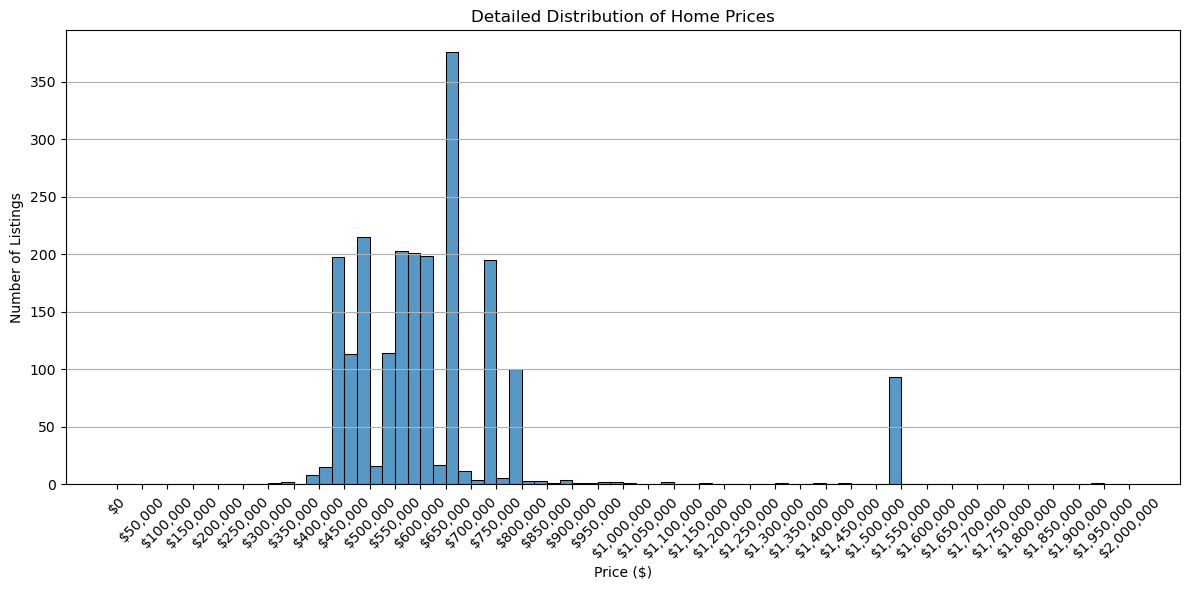

In [48]:
import matplotlib.ticker as mtick

# Set a cap at $2M for visibility
price_cap = min(df['price'].max(), 2000000)

# Bins every $25K
bins = range(0, int(price_cap) + 25000, 25000)

plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=bins, kde=False)

plt.title('Detailed Distribution of Home Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')

# Set x-axis ticks every $50K
xticks = range(0, int(price_cap) + 50000, 50000)
plt.xticks(ticks=xticks, rotation=45)

# Format x-axis labels as currency
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.grid(axis='y')
plt.tight_layout()
plt.show()


# HOA vs Non-HOA Homes 

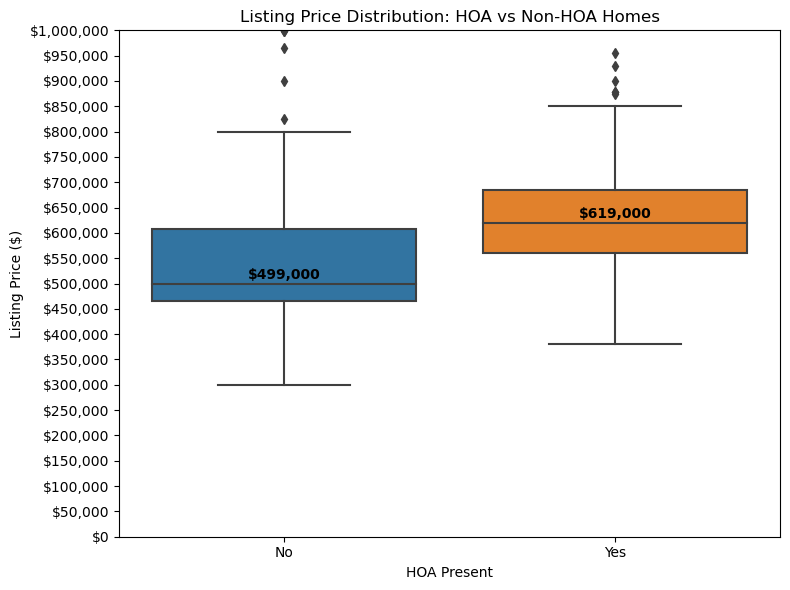

In [49]:
# Step: Create HOA category: Yes/No
df['hoa_flag'] = df['hoa'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Plot with improved formatting
import matplotlib.ticker as ticker

# Revert to original price axis with better y-axis ticks
plt.figure(figsize=(8, 6))
sns.boxplot(x='hoa_flag', y='price', data=df)
plt.title('Listing Price Distribution: HOA vs Non-HOA Homes')
plt.xlabel('HOA Present')
medians = df.groupby('hoa_flag')['price'].median()
for i, median in enumerate(medians):
    plt.text(i, median + 10000, f'${median:,.0f}', ha='center', color='black', fontweight='bold')

plt.ylabel('Listing Price ($)')


# Format price in y-axis
ax = plt.gca()
ax.set_ylim(0, 1000000)  # Cap y-axis at $1M
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()


### Housing price in general range between 375k - 800k without HOA while the majority of the property with HOA priced between 400k to 650k. 

# Predictive Value modeling

#### build a model to predict a house's price per square foot based on its features. That way, we can estimate residuals.

#### To learn how features affect pricing, we start with linear regression, then we will try Random Forest Regressor and see if we can predict the price without assuming linearity.
#### If random forest has better prediction than linear regression, we could consider using XGBoost. 


## Linear Regression

#### Although not likely due to the nature of housing prices, we could try to see if there is a linear relationship between features in the dataframe and price_per_sqft.

In [50]:
# Extract ZIP code (5-digit) from the 'address' column
df['zip'] = df['address'].str.extract(r'(\d{5})')
df['zip'] = df['zip'].astype(str)

# Clean 'sqft' column: remove commas, extract numeric part, convert to float
df['sqft'] = df['sqft'].astype(str)
df['sqft'] = df['sqft'].str.replace(',', '', regex=False)
df['sqft'] = df['sqft'].str.extract(r'(\d+)')[0]
df['sqft'] = df['sqft'].astype(float)

# Clean 'beds' column: extract number (can include decimal), convert to float
df['beds'] = df['beds'].astype(str)
df['beds'] = df['beds'].str.extract(r'(\d+\.?\d*)')[0]
df['beds'] = df['beds'].astype(float)

# Clean 'baths' column: extract number (can include decimal), convert to float
df['baths'] = df['baths'].astype(str)
df['baths'] = df['baths'].str.extract(r'(\d+\.?\d*)')[0]
df['baths'] = df['baths'].astype(float)

# Clean 'hoa' column: remove $ and '/mo', convert to float
df['hoa'] = df['hoa'].astype(str)
df['hoa'] = df['hoa'].str.replace('$', '', regex=False)
df['hoa'] = df['hoa'].str.replace('/mo', '', regex=False)
df['hoa'] = df['hoa'].astype(float)


In [51]:
# Select the relevant columns
selected_features = ['sqft', 'beds', 'baths', 'year_built', 'hoa', 'zip']
target = 'price_per_sqft'


# Create a working copy of the dataframe
df_model = df[selected_features +[target]].dropna()


# Separate features and target
X=df_model[selected_features]
y=df_model[target]

# Identify categorical columns to encode (zip is the only one)
categorical_features = ['zip']
numerical_features = ['sqft', 'beds', 'baths', 'year_built', 'hoa']

# One-hot encode ZIP code
X_encoded = pd.get_dummies(X, columns=categorical_features, prefix='zip')

# Let’s preview the shape of your features
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (2118, 6)
Target vector shape: (2118,)


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) 

#X_train =80% of features from df
#y_train = actual target (price_per_sqft) for the training data
#X_test  = Unknown feature (trying to find out)
#y_test = real prices for the test home

# Check shapes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (1694, 6)
Testing set size: (424, 6)


Train and Evalute model

In [63]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train) # Model looks at X_train and try to find patterns that match y_train (price_per_sqft)
y_pred = linear_model.predict(X_test) # y_pred = The model's prediction based on X-test

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R² Score: {r2:.3f}")

Linear Regression RMSE: 27.84
Linear Regression R² Score: 0.430


### Linear regression does not usually serve well in predicting for housing market simply because the market is very dynamic and linear relationship between features does not always correspond to prices.
### However, linear regression provides us a baseline to compare with random forest model, which handles non-linear relationships and that works better for building a more accurate predicting model for housing prices.

## Random Forest Modeling

### We are examing whether if there features in a property like sqft, beds, bath, year_built, hoa and zip could affect price_per_sqft.

In [64]:
from sklearn.ensemble import RandomForestRegressor

# Clean and prepare data
def clean_redfin_data(df):
    # Extract ZIP code from 'address'
    df['zip'] = df['address'].astype(str).str.extract(r'(\d{5})')
    
    # Clean and convert numeric fields
    def clean_numeric_column(col, remove_str = None):
        col = col.astype(str)
        if remove_str:
            col = col.str.replace(remove_str, '', regex=False)
        col = col.str.replace(',', '').str.extract(r'(\d+\.?\d*)')[0]
        return col.astype(float)
    
    df['sqft'] = clean_numeric_column(df['sqft'])
    df['beds'] = clean_numeric_column(df['beds'])
    df['baths'] = clean_numeric_column(df['baths'])
    df['hoa'] = clean_numeric_column(df['hoa'], remove_str='/mo')
    df['price'] = clean_numeric_column(df['price'])

# Calculate price per sqft
df['price_per_sqft'] = df['price'] / df['sqft']

# Drop rows with missing or invalid values
df = df.dropna(subset=['sqft', 'beds', 'baths', 'year_built', 'hoa', 'price', 'price_per_sqft', 'zip'])
df = df[df['price_per_sqft'] > 0]

# Select features and target
features = ['sqft', 'beds', 'baths', 'year_built', 'hoa', 'zip']
target = 'price_per_sqft'

# One-hot encode ZIP code
X = pd.get_dummies(df[features], columns=['zip'], prefix='zip')
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#80% X-train and y-train, 20% X-test, y-test

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, random_state=50)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R² Score: {r2:.3f}")

# Step: Identify undervalued homes
investment_df = X_test.copy()
investment_df['actual_price_per_sqft'] = y_test.values
investment_df['predicted_price_per_sqft'] = y_pred
investment_df['undervaluation'] = investment_df['predicted_price_per_sqft'] - investment_df['actual_price_per_sqft']

# Restore readable ZIP column
zip_columns = [col for col in investment_df.columns if col.startswith('zip_')]
investment_df['zip'] = investment_df[zip_columns].idxmax(axis=1).str.replace('zip_', '')

# Group by ZIP to find systemic undervaluation
zip_agg = investment_df.groupby('zip').agg({
    'actual_price_per_sqft': 'mean',
    'predicted_price_per_sqft': 'mean',
    'undervaluation': ['mean', 'count']
})

# Clean up column names
zip_agg.columns = ['actual_price_per_sqft', 'predicted_price_per_sqft', 'avg_undervaluation', 'num_homes']
zip_agg = zip_agg.sort_values(by='avg_undervaluation', ascending=False)

# Display top undervalued ZIP codes
pd.options.display.float_format = '{:.2f}'.format
display(zip_agg.head(10))

Random Forest RMSE: 13.64
Random Forest R² Score: 0.863


,actual_price_per_sqft,predicted_price_per_sqft,avg_undervaluation,num_homes
zip,,,,
85225,312.92,326.48,13.56,24
85249,267.17,275.77,8.60,47
85226,270.03,272.08,2.05,55
85286,263.95,264.51,0.55,18
85224,300.38,300.63,0.25,38
85204,212.31,212.31,0.00,12
85042,326.09,326.09,0.00,20
16235,311.14,311.14,0.00,27
85296,261.24,261.24,-0.00,16


In [65]:
# RMSE13.46 and R2 score shows 87% prediction accuracy 

# Findings: 
### Homes are undervalued by about $12.83 per sqft.
### This makes them ideal for flipping or long-term appreciation.
### For buyers: 85225 may offer better value for money right now. This helps first-time buyers or smart shoppers find good deals — not get priced out.

# XGBoost Modeling for Nonlinear data

In [66]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [71]:
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state = 42)
xgb_model.fit(X_train, y_train)

y_pred_xgb= xgb_model.predict(X_test)
xgb_rmse=np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2=r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {xgb_rmse:.2f}") 
print(f"XGBoost R² Score: {xgb_r2:.2f}")

XGBoost RMSE: 14.27
XGBoost R² Score: 0.85


<Figure size 1000x800 with 0 Axes>

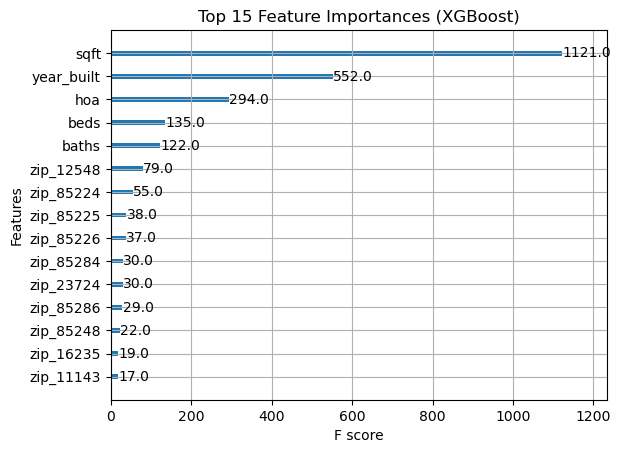

In [68]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importances
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=15)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

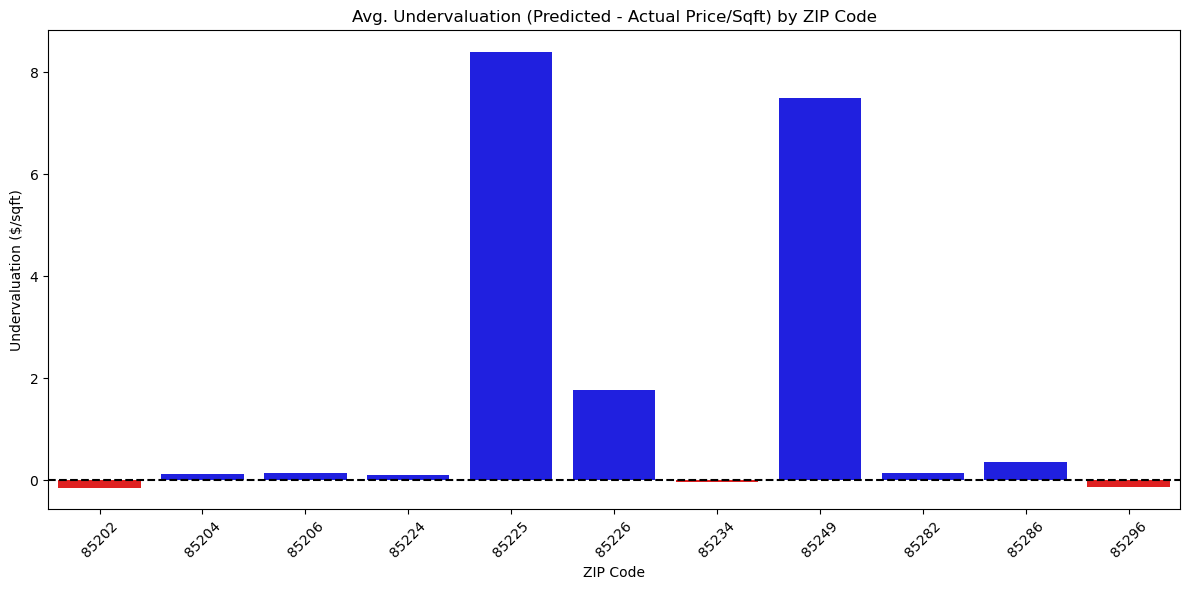

In [69]:
# ZIP-level undervaluation analysis
investment_df = X_test.copy()
investment_df['actual_price_per_sqft'] = y_test.values
investment_df['predicted_price_per_sqft'] = y_pred_xgb
investment_df['undervaluation'] = investment_df['predicted_price_per_sqft'] - investment_df['actual_price_per_sqft']

# Restore ZIP info from one-hot encoded columns
zip_columns = [col for col in investment_df.columns if col.startswith('zip_852')]
investment_df['zip'] = investment_df[zip_columns].idxmax(axis=1).str.replace('zip_', '')

#Group by ZIP
zip_summary = investment_df.groupby('zip').agg({
    'actual_price_per_sqft': 'mean',
    'predicted_price_per_sqft': 'mean',
    'undervaluation': 'mean'
}).reset_index()
zip_summary['num_listings'] = investment_df.groupby('zip').size().values
zip_summary = zip_summary[zip_summary['num_listings'] >= 5]

# Plot
zip_summary['color'] = zip_summary['undervaluation'].apply(lambda x: 'blue' if x > 0 else 'red')
plt.figure(figsize=(12, 6))
sns.barplot(data=zip_summary, x='zip', y='undervaluation', palette=zip_summary['color'])
plt.title("Avg. Undervaluation (Predicted - Actual Price/Sqft) by ZIP Code")
plt.ylabel("Undervaluation ($/sqft)")
plt.xlabel("ZIP Code")
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TOP 5 undervalued and overvalued zipcode

In [70]:
top_under = zip_summary.sort_values(by='undervaluation', ascending=False).head(5)
top_over = zip_summary.sort_values(by='undervaluation').head(5)

display(top_under[['zip', 'undervaluation', 'num_listings']])
display(top_over[['zip', 'undervaluation', 'num_listings']])

# Show homes in a top undervalued ZIP
top_zip = top_under.iloc[0]['zip']
undervalued_homes = investment_df[investment_df['zip'] == top_zip].copy()

# Add address back in from original df (if needed)
undervalued_homes = undervalued_homes.merge(df[['address', 'zip']], on='zip', how='left')

# Show top 5
display(undervalued_homes.sort_values(by='undervaluation', ascending=False).head(5))


,zip,undervaluation,num_listings
4,85225,8.39,24
7,85249,7.49,47
5,85226,1.77,55
9,85286,0.36,18
8,85282,0.14,22


,zip,undervaluation,num_listings
0,85202,-0.14,134
10,85296,-0.13,16
6,85234,-0.03,35
3,85224,0.11,38
1,85204,0.12,12


,sqft,beds,baths,year_built,hoa,zip_11143,zip_12036,zip_12228,zip_12501,zip_12548,...,zip_85282,zip_85284,zip_85286,zip_85296,zip_85297,actual_price_per_sqft,predicted_price_per_sqft,undervaluation,zip,address
196,1476.00,4.00,3.00,1947.00,0.00,False,False,False,False,False,...,False,False,False,False,False,315.04,448.76,133.72,85225,"1298 E Buffalo St, Chandler, AZ 85225"
216,1476.00,4.00,3.00,1947.00,0.00,False,False,False,False,False,...,False,False,False,False,False,315.04,448.76,133.72,85225,"231 N Nash Way, Chandler, AZ 85225"
194,1476.00,4.00,3.00,1947.00,0.00,False,False,False,False,False,...,False,False,False,False,False,315.04,448.76,133.72,85225,"1903 E Jasper Dr, Chandler, AZ 85225"
195,1476.00,4.00,3.00,1947.00,0.00,False,False,False,False,False,...,False,False,False,False,False,315.04,448.76,133.72,85225,"240 N Monte Vista St, Chandler, AZ 85225"
197,1476.00,4.00,3.00,1947.00,0.00,False,False,False,False,False,...,False,False,False,False,False,315.04,448.76,133.72,85225,"914 W Morelos St, Chandler, AZ 85225"


# Pricing Strategy

### Assuming a $5/sqft between actual and predcited price is significant, which is a conserative pricing strategy. This could avoid overpricing while gaining some value. This price set is only for analysis purpose, the actual price margin could be consulted with professionally licensed real estate agents. 

In [62]:
threshold = investment_df['undervaluation'].std()

# Apply pricing strategy based on threshold
def apply_pricing_strategy(row):
    if row['undervaluation'] > threshold:
        return 'Raise price moderately (Undervalued)'
    elif row['undervaluation'] < -threshold:
        return 'Consider lowering price (Overvalued)'
    else:
        return 'Price near market value (Fair)'

investment_df['strategy'] = investment_df.apply(apply_pricing_strategy, axis=1)

# Suggest target price/sqft based on strategy
investment_df['target_price_per_sqft'] = investment_df.apply(
    lambda row: row['actual_price_per_sqft'] + 5 if 'Raise' in row['strategy']
    else row['actual_price_per_sqft'] - 5 if 'lowering' in row['strategy']
    else row['predicted_price_per_sqft'], axis=1
)

# Display sample output
investment_df[['zip', 'actual_price_per_sqft', 'predicted_price_per_sqft',
               'undervaluation', 'strategy', 'target_price_per_sqft']].sort_values(
    by='undervaluation', ascending=False).head(10)


,zip,actual_price_per_sqft,predicted_price_per_sqft,undervaluation,strategy,target_price_per_sqft
245,85225,315.04,448.76,133.72,Raise price moderately (Undervalued),320.04
33,85225,183.89,266.10,82.20,Raise price moderately (Undervalued),188.89
284,85225,183.89,266.10,82.20,Raise price moderately (Undervalued),188.89
242,85249,169.12,232.07,62.95,Raise price moderately (Undervalued),174.12
115,85225,313.48,371.42,57.94,Raise price moderately (Undervalued),318.48
238,85249,224.70,282.05,57.35,Raise price moderately (Undervalued),229.70
207,85225,303.70,359.80,56.11,Raise price moderately (Undervalued),308.70
202,85249,239.91,292.84,52.93,Raise price moderately (Undervalued),244.91
167,85249,250.85,302.80,51.95,Raise price moderately (Undervalued),255.85
69,85249,226.24,272.31,46.07,Raise price moderately (Undervalued),231.24


# Summary:
### As of July, 2025: 

### Buyers: Target overvalued ZIPs for negotiations; focus on homes where model suggests pricing is too high.

### Sellers: In ZIPs like 85225 and 85249, market may tolerate a higher price — good places to raise listing prices.

### Investors: Look for consistent undervaluation gaps in ZIPs with high listing count for resale or rental opportunities.

### XGBoost model AND Random Forest shows that square footage is the most influential factor in determining home value per sqft. This suggests a pricing sensitivity to home size across Chandler. By identifying large homes that are priced below their predicted value per sqft, we can pinpoint properties that are likely undervalued — ideal for investor acquisition or buyer negotiation leverage."